**Load Modules**

In [1]:
import os, glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm 
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

import re
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

import cartopy.crs as ccrs
import cartopy.feature as cfeature



# **1. Process data**

## **1.1 Statistic 30 deg lat band time series daily data (mean+std)**

In [ ]:

DATA_DIR     = "../XCO2_prediction_full"
FILE_PATTERN = "monthly_xco2_full_*.npy"
START_DATE   = "2019-01-01"
END_DATE     = "2024-12-31"
USE_WEIGHTS  = False 
BAND_WIDTH   = 30   

def load_npy_any(npy_path, allow_fallback=False):
    try:
        arr = np.load(npy_path, allow_pickle=False, mmap_mode='r')
        names = arr.dtype.names
        if names:
            if all(c in names for c in ["lat", "lon", "time", "xco2_pred"]):
                return {
                    "lat":  np.array(arr["lat"]),
                    "lon":  np.array(arr["lon"]),
                    "time": pd.to_datetime(np.array(arr["time"])),
                    "xco2": np.array(arr["xco2_pred"]),
                }
            if allow_fallback and all(c in names for c in ["lat", "lon", "time", "xco2"]):
                return {
                    "lat":  np.array(arr["lat"]),
                    "lon":  np.array(arr["lon"]),
                    "time": pd.to_datetime(np.array(arr["time"])),
                    "xco2": np.array(arr["xco2"]),
                }
            raise ValueError(f"{npy_path} 缺少 xco2_pred 列")
    except Exception:
        pass

    arr = np.load(npy_path, allow_pickle=True)
    if isinstance(arr, dict):
        df = pd.DataFrame(arr)
    elif getattr(arr, "dtype", None) is not None and arr.dtype.names is not None:
        df = pd.DataFrame(arr)
    else:
        df = pd.DataFrame(list(arr))

    if "xco2_pred" in df.columns:
        df = df.rename(columns={"xco2_pred": "xco2"})
    elif allow_fallback and "xco2" in df.columns:
        pass
    else:
        raise ValueError(f"{npy_path}can not find")
    keep = [c for c in ["lat", "lon", "time", "xco2"] if c in df.columns]
    df = df[keep].copy()
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    return {k: df[k].to_numpy() for k in ["lat", "lon", "time", "xco2"]}

def build_lat_bands(band_width=30):
    edges = np.arange(-90, 90 + band_width, band_width, dtype=float)
    if edges[-1] != 90:
        edges = np.append(edges, 90.0)
    labels = []
    for i in range(len(edges)-1):
        left, right = edges[i], edges[i+1]
        labels.append(f"[{int(left)},{int(right)})")
    return edges, labels

EDGES, BAND_LABELS = build_lat_bands(BAND_WIDTH)

acc_bands = {lab: {} for lab in BAND_LABELS}

def accumulate_by_band(lat, time, xco2):
    mask_t = (time >= pd.to_datetime(START_DATE)) & (time <= pd.to_datetime(END_DATE))
    if not np.any(mask_t):
        return
    lat  = lat[mask_t]
    time = time[mask_t]
    xco2 = xco2[mask_t]

    w = (np.cos(np.deg2rad(np.abs(lat))).astype(np.float32)
         if USE_WEIGHTS else np.ones_like(lat, dtype=np.float32))
    dates = pd.to_datetime(time).floor('D').to_numpy()
    band_cats = pd.cut(
        lat, bins=EDGES, right=False, include_lowest=True, labels=BAND_LABELS
    )

    tmp = pd.DataFrame({
        "date": dates,
        "band": band_cats.astype("category"),
        "w":    w,
        "wx":   w * xco2,
        "wx2":  w * (xco2.astype(np.float64) ** 2),
    })
    g = tmp.groupby(["date", "band"], sort=False, as_index=False).sum(numeric_only=True)

    for _, row in g.iterrows():
        d    = row["date"]
        band = row["band"]
        sw, swx, swx2 = float(row["w"]), float(row["wx"]), float(row["wx2"])
        acc = acc_bands[band]
        if d in acc:
            acc[d][0] += sw
            acc[d][1] += swx
            acc[d][2] += swx2
        else:
            acc[d] = [sw, swx, swx2]

def acc_to_timeseries(acc_dict):
    if not acc_dict:
        return pd.DataFrame(columns=["date", "mean", "std"])
    dates = sorted(acc_dict.keys())
    sw   = np.array([acc_dict[d][0] for d in dates], dtype=np.float64)
    swx  = np.array([acc_dict[d][1] for d in dates], dtype=np.float64)
    swx2 = np.array([acc_dict[d][2] for d in dates], dtype=np.float64)
    mean = swx / sw
    var  = np.maximum(swx2 / sw - mean**2, 0.0)
    std  = np.sqrt(var)
    return pd.DataFrame({"date": dates, "mean": mean, "std": std}).sort_values("date")

files = sorted(glob.glob(os.path.join(DATA_DIR, FILE_PATTERN)))
if not files:
    raise FileNotFoundError(f"Cannot find {os.path.join(DATA_DIR, FILE_PATTERN)}")

pbar = tqdm(files, desc="Processing monthly .npy files", unit="file")
for f in pbar:
    cols = load_npy_any(f)
    nrows = len(cols["xco2"])
    tmin = pd.to_datetime(cols["time"]).min()
    tmax = pd.to_datetime(cols["time"]).max()
    pbar.set_postfix(rows=nrows, start=str(tmin.date()), end=str(tmax.date()))
    accumulate_by_band(cols["lat"], cols["time"], cols["xco2"])
    del cols

ts_by_band = {band: acc_to_timeseries(acc_bands[band]) for band in BAND_LABELS}

ts_long = pd.concat(
    [df.assign(band=band) for band, df in ts_by_band.items()],
    axis=0, ignore_index=True
)[["date", "band", "mean", "std"]].sort_values(["band", "date"])

## **1.2 Save results and convenient to read later**

In [ ]:
OUTPUT_DIR = "./xco2_band_outputs_csv"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ts_long = ts_long.copy()
ts_long["date"] = pd.to_datetime(ts_long["date"])

combined_csv = os.path.join(OUTPUT_DIR, "xco2_timeseries_by_lat_band.csv")
ts_long.to_csv(
    combined_csv,
    index=False,
    float_format="%.6f", 
    date_format="%Y-%m-%d" 
)

for band, df in ts_by_band.items():
    if df.empty:
        continue
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    safe_band = band.replace("[","").replace(")","").replace("(","").replace(",","_").replace("]","")
    out_csv = os.path.join(OUTPUT_DIR, f"xco2_timeseries_band_{safe_band}.csv")
    df.to_csv(
        out_csv,
        index=False,
        float_format="%.6f",
        date_format="%Y-%m-%d"
    )

meta = {
    "data_dir": DATA_DIR,
    "file_pattern": FILE_PATTERN,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "use_weights": USE_WEIGHTS,
    "band_width_deg": BAND_WIDTH,
    "lat_band_edges": [float(x) for x in EDGES],
    "lat_band_labels": BAND_LABELS,
    "num_files": len(files)
}
with open(os.path.join(OUTPUT_DIR, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"CSV files saved under: {OUTPUT_DIR}")

# **2. Plot Figures**

## **2.1 Plot the daily variations**

In [ ]:
def _ensure_datetime(df, col="date"):
    if not np.issubdtype(df[col].dtype, np.datetime64):
        df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

def save_daily_by_bands(
    ts_long: pd.DataFrame,
    outdir=".",
    fname="daily_by_bands.png",
    bands=None,        
    smooth_days=0,      
    show_shading=True,  
):
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    cols = [c for c in ["date", "band", "mean", "std"] if c in ts_long.columns]
    df = ts_long[cols].copy()
    df = _ensure_datetime(df, "date").dropna(subset=["date", "band", "mean"])

    if bands is None:
        def band_key(b):
            try:
                return float(str(b).split(",")[0].strip("[("))
            except Exception:
                return 0.0
        bands = sorted(df["band"].astype(str).unique(), key=band_key)

    import itertools
    from matplotlib.cm import get_cmap
    blues = get_cmap("Blues")
    reds  = get_cmap("Reds")

    color_cycle = itertools.cycle([blues(0.9), blues(0.6), blues(0.3), reds(0.3), reds(0.6), reds(0.9)])

    fig, ax = plt.subplots(figsize=(15, 5.0))

    for band in bands:
        sub = df[df["band"].astype(str) == str(band)].sort_values("date")
        if sub.empty:
            continue
        m = sub["mean"].astype(float)
        s = sub["std"].astype(float) if "std" in sub else pd.Series(np.nan, index=sub.index)

        if smooth_days and smooth_days > 0:
            m = m.rolling(smooth_days, min_periods=max(1, smooth_days//2), center=True).mean()
            s = s.rolling(smooth_days, min_periods=max(1, smooth_days//2), center=True).mean()

        c = next(color_cycle)
        ax.plot(sub["date"], m, lw=1.4, label=str(band), color=c)
        if show_shading and np.isfinite(s).any():
            ax.fill_between(sub["date"], m - s, m + s, alpha=0.18, color=c, linewidth=0)

    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel("XCO$_2$ (ppm)", fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

    def band_pretty(band_str: str) -> str:
        """ '[-90,-60)' -> '90°S–60°S'，'[0,30)' -> '0°–30°N' 等 """
        m = re.match(r"[\[\(]\s*([-+]?\d+\.?\d*)\s*,\s*([-+]?\d+\.?\d*)\s*[\)\]]", str(band_str).strip())
        if not m:
            return band_str 
        lo, hi = float(m.group(1)), float(m.group(2))

        def fmt(v):
            sign = "S" if v < 0 else ("N" if v > 0 else "")
            deg  = f"{abs(v):g}°"
            return f"{deg}{sign}" if sign else deg 

        return f"{fmt(lo)}–{fmt(hi)}"

    handles, labels = ax.get_legend_handles_labels()
    pretty_labels = [band_pretty(lbl) for lbl in labels]

    ax.legend(
        handles, pretty_labels,ncol=2, fontsize=16, loc="upper left",
        handlelength=1.5,    
        handletextpad=0.7,  
        borderpad=0.3,     
        columnspacing=1.4,  
        labelspacing=0.8, 
        frameon=False    
    )

    fig.tight_layout()
    for side in ["top", "bottom", "left", "right"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.0)
    #ax.grid(True, alpha=0.4,linestyle="--",linewidth=0.7) 
    out_path = outdir / fname
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"✅ Saved: {out_path}")

BAND_CSV_DIR = Path("xco2_band_outputs_csv")
ts_long = pd.read_csv(
    BAND_CSV_DIR / "xco2_timeseries_by_lat_band.csv",
    parse_dates=["date"]  
)

save_daily_by_bands(ts_long, outdir="figs", fname="daily_by_bands_all.png", smooth_days=3)

## **2.2 Plot seasonal figures**

In [5]:
BAND_CSV_DIR = Path("xco2_band_outputs_csv") 
OUTDIR = Path("figs")
OUTDIR.mkdir(parents=True, exist_ok=True)

mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,
    "grid.alpha": 0.25,
    "legend.frameon": False,
})

def _monthly_series_from_ts(ts):

    daily = ts.set_index("date")[["mean"]].copy()
    daily.index = pd.to_datetime(daily.index)
    monthly = daily.resample("MS").mean()
    monthly["mean"] = monthly["mean"].interpolate(limit_direction="both")
    return monthly

def _ssa_reconstruct_season(x, L=24, comps=(1, 2)):

    x = np.asarray(x, dtype=float)
    N = x.size
    if not (2 <= L <= N // 2):
        L = max(2, min(24, N // 2))
    K = N - L + 1
    X = np.column_stack([x[i:i+L] for i in range(K)])  
    U, s, Vt = np.linalg.svd(X, full_matrices=False)  

    X_rec = np.zeros_like(X)
    for c in comps:
        if c < len(s):
            X_rec += s[c] * np.outer(U[:, c], Vt[c, :])
    y = np.zeros(N)
    counts = np.zeros(N)
    for i in range(L):
        for j in range(K):
            y[i + j] += X_rec[i, j]
            counts[i + j] += 1
    counts[counts == 0] = 1
    y /= counts
    return y

def ssa_monthly_stats(
    ts,
    L=24,
    comps=(1, 2),
    center_by_year=True,
    q=(0.1, 0.9),
    years=(2019, 2024),  
    date_range=None,          
    full_years_only=False,     
):

    monthly = _monthly_series_from_ts(ts)     

    if date_range is not None:
        start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    else:
        y0, y1 = years
        start = pd.Timestamp(f"{y0}-01-01")
        end   = pd.Timestamp(f"{y1}-12-31")
    monthly = monthly.loc[(monthly.index >= start) & (monthly.index <= end)].copy()

    mon_vals = monthly["mean"].to_numpy()
    mon_time = monthly.index
    y_ssa = _ssa_reconstruct_season(mon_vals, L=L, comps=comps)

    df = pd.DataFrame({"ssa": y_ssa}, index=mon_time)
    df["year"] = df.index.year
    df["month"] = df.index.month
    if full_years_only:
        good = df.groupby("year")["month"].nunique()
        df = df[df["year"].isin(good[good == 12].index)]

    if center_by_year:
        df["ssa_center"] = df["ssa"] - df.groupby("year")["ssa"].transform("mean")
    else:
        df["ssa_center"] = df["ssa"] - df["ssa"].mean()
    use_col = "ssa_center"

    tab = df.pivot_table(index="month", columns="year", values=use_col, aggfunc="mean").sort_index()

    mean   = tab.mean(axis=1, skipna=True)
    std    = tab.std(axis=1, ddof=1, skipna=True)
    q_low  = tab.quantile(q[0], axis=1, interpolation="linear")
    q_high = tab.quantile(q[1], axis=1, interpolation="linear")
    n_years = tab.notna().sum(axis=1)

    return {
        "months": mean.index.to_numpy(), 
        "mean":   mean.to_numpy(),
        "std":    std.to_numpy(),
        "q_low":  q_low.to_numpy(),
        "q_high": q_high.to_numpy(),
        "n_years": n_years.to_numpy(),
        "table":  tab
    }

def _ensure_datetime(df, col="date"):
    if not np.issubdtype(df[col].dtype, np.datetime64):
        df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

def format_band_label(safe_band: str) -> str:
    lo_str, hi_str = safe_band.split("_")
    lo = float(lo_str)
    hi = float(hi_str)

    def fmt_lat(x):
        if x == 0:
            return "0°"
        sign = "N" if x > 0 else "S"
        return f"{abs(int(x))}°{sign}"

    return f"{fmt_lat(lo)}–{fmt_lat(hi)}"

band_files = sorted(BAND_CSV_DIR.glob("xco2_timeseries_band_*.csv"))
if not band_files:
    raise FileNotFoundError(f"No band CSVs found under {BAND_CSV_DIR}")

stats_by_band = {} 

for fpath in band_files:
    safe_band = fpath.stem.replace("xco2_timeseries_band_", "") 
    df = pd.read_csv(fpath)
    df = _ensure_datetime(df, "date")
    df = df.sort_values("date")

    stats = ssa_monthly_stats(
        df,
        L=24,
        comps=(1, 2),
        years=(2019, 2024)
    )
    stats_by_band[safe_band] = stats

In [ ]:
def plot_ssa_monthly_all_bands(stats_by_band, fname="season_SSA_all_lat_bands.png"):
    def band_key(sb):
        lo = float(sb.split("_")[0])
        return lo
    ordered_bands = sorted(stats_by_band.keys(), key=band_key)

    cmap = mpl.cm.get_cmap("coolwarm", len(ordered_bands))

    fig, ax = plt.subplots(figsize=(15, 5.0))

    for i, safe_band in enumerate(ordered_bands):
        stats = stats_by_band[safe_band]
        months = stats["months"]
        mu = stats["mean"]
        sd = stats["std"]

        label = format_band_label(safe_band)
        color = cmap(i)

        ax.plot(
            months, mu,
            lw=2.0,
            marker="o",
            ms=3.5,
            color=color,
            label=label,
        )
        if np.isfinite(sd).any():
            ax.fill_between(months, mu - sd, mu + sd, color=color, alpha=0.15)

    ax.set_xlabel("Month",fontsize=16)
    ax.set_ylabel("XCO$_2$ anomaly (ppm)", fontsize=16)
    ax.set_xlim(1, 12)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    all_vals = []
    for stats in stats_by_band.values():
        mu = stats["mean"]
        sd = stats["std"]
        if np.isfinite(sd).any():
            all_vals.append(mu - sd)
            all_vals.append(mu + sd)
        else:
            all_vals.append(mu)
    all_vals = np.concatenate([np.asarray(v) for v in all_vals]) if all_vals else np.array([0.0])
    yabs = np.nanmax(np.abs(all_vals))
    if np.isfinite(yabs) and yabs > 0:
        ax.set_ylim(-1.1 * yabs, 1.1 * yabs)

    import re

    def band_pretty(band_str: str) -> str:
        """ '[-90,-60)' -> '90°S–60°S'，'[0,30)' -> '0°–30°N' 等 """
        m = re.match(r"[\[\(]\s*([-+]?\d+\.?\d*)\s*,\s*([-+]?\d+\.?\d*)\s*[\)\]]", str(band_str).strip())
        if not m:
            return band_str 
        lo, hi = float(m.group(1)), float(m.group(2))

        def fmt(v):
            sign = "S" if v < 0 else ("N" if v > 0 else "")
            deg  = f"{abs(v):g}°" 
            return f"{deg}{sign}" if sign else deg 

        return f"{fmt(lo)}–{fmt(hi)}"  # 使用 en dash

    handles, labels = ax.get_legend_handles_labels()
    pretty_labels = [band_pretty(lbl) for lbl in labels]
    
    ax.legend(
        handles, pretty_labels,ncol=2, fontsize=16, loc="upper right",
        handlelength=1.5, 
        handletextpad=0.7,     
        borderpad=0.3,       
        columnspacing=1.4,  
        labelspacing=0.8, 
        frameon=False      
    )
    #ax.grid(True, alpha=0.4,linestyle="--",linewidth=0.7) 
    for side in ["top", "bottom", "left", "right"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.0)

    fig.tight_layout()
    fig.savefig(OUTDIR / fname, bbox_inches="tight")
    plt.close(fig)

plot_ssa_monthly_all_bands(stats_by_band,
                           fname="season_SSA_all_lat_bands.png")


# **3. Plot SSA_grid**

In [3]:
DATA_DIR = Path("../XCO2_prediction_full")
FILE_PATTERN = "monthly_xco2_full_*.npy"

MONTHLY_DIR = DATA_DIR / "XCO2_prediction_monthly_means"
MONTHLY_DIR.mkdir(parents=True, exist_ok=True)

OUTDIR = Path("figs_xco2_seasonal_variation")
OUTDIR.mkdir(parents=True, exist_ok=True)

### **Merge daily to monthly and save**

In [ ]:
monthly_maps = []   
monthly_dates = [] 
lat_arr = None
lon_arr = None

def parse_year_month(fname: str):
    stem = Path(fname).stem
    parts = stem.split("_")
    year = int(parts[-2])
    month = int(parts[-1])
    return year, month

for fpath in sorted(DATA_DIR.glob(FILE_PATTERN)):
    print(f"[INFO] Reading {fpath.name}")
    raw = np.load(fpath, allow_pickle=True)
    if isinstance(raw, np.ndarray) and raw.dtype == object:
        arr = raw.item()
    elif isinstance(raw, dict):
        arr = raw
    elif hasattr(raw, "dtype") and raw.dtype.names is not None:
        arr = {name: raw[name] for name in raw.dtype.names}
    else:
        raise ValueError(f"Unrecognized npy format for {fpath}")

    df = pd.DataFrame({
        "lat":  np.array(arr["lat"]),
        "lon":  np.array(arr["lon"]),
        "time": pd.to_datetime(np.array(arr["time"])),
        "xco2_pred": np.array(arr["xco2_pred"])
    }).dropna(subset=["lat", "lon", "time", "xco2_pred"])

    df["year"] = df["time"].dt.year
    df["month"] = df["time"].dt.month

    g = df.groupby(["lat", "lon", "year", "month"], as_index=False)["xco2_pred"].mean()

    year = int(g["year"].iloc[0])
    month = int(g["month"].iloc[0])
    month_date = pd.Timestamp(year=year, month=month, day=1)
    monthly_dates.append(month_date)

    if lat_arr is None:
        lat_arr = np.sort(g["lat"].unique())
        lon_arr = np.sort(g["lon"].unique())
        print(f"[INFO] lat_arr shape: {lat_arr.shape}, lon_arr shape: {lon_arr.shape}")
    else:

        if not np.array_equal(lat_arr, np.sort(g["lat"].unique())) or \
           not np.array_equal(lon_arr, np.sort(g["lon"].unique())):
            raise ValueError("lat/lon values changed between files!")

    nlat = len(lat_arr)
    nlon = len(lon_arr)

    grid = np.full((nlat, nlon), np.nan, dtype="float32")
    lat_idx = np.searchsorted(lat_arr, g["lat"].to_numpy())
    lon_idx = np.searchsorted(lon_arr, g["lon"].to_numpy())

    grid[lat_idx, lon_idx] = g["xco2_pred"].to_numpy()

    monthly_maps.append(grid)

    out_dict = {
        "lat": lat_arr,         
        "lon": lon_arr,              
        "time": month_date,        
        "xco2_month_mean": grid       
    }
    out_name = MONTHLY_DIR / f"xco2_monthmean_{year}_{month:02d}.npy"
    np.save(out_name, out_dict)
    print(f"[INFO] Saved monthly mean: {out_name}")

monthly_maps = np.stack(monthly_maps, axis=0)   # shape: (T, nlat, nlon)
monthly_dates = np.array(monthly_dates)         # shape: (T,)

print(f"[INFO] Monthly stack shape: {monthly_maps.shape}")
print(f"[INFO] Example time span: {monthly_dates.min()} ~ {monthly_dates.max()}")

### **Define Functions for SSA**

In [ ]:

def _monthly_series_from_ts(ts):
    daily = ts.set_index("date")[["mean"]].copy()
    daily.index = pd.to_datetime(daily.index)
    monthly = daily.resample("MS").mean()
    monthly["mean"] = monthly["mean"].interpolate(limit_direction="both")
    return monthly

def _ssa_reconstruct_season(x, L=24, comps=(1, 2)):
    x = np.asarray(x, dtype=float)
    N = x.size
    if not (2 <= L <= N // 2):
        L = max(2, min(24, N // 2))
    K = N - L + 1
    X = np.column_stack([x[i:i+L] for i in range(K)]) 
    U, s, Vt = np.linalg.svd(X, full_matrices=False) 
    X_rec = np.zeros_like(X)
    for c in comps:
        if c < len(s):
            X_rec += s[c] * np.outer(U[:, c], Vt[c, :])
    y = np.zeros(N)
    counts = np.zeros(N)
    for i in range(L):
        for j in range(K):
            y[i + j] += X_rec[i, j]
            counts[i + j] += 1
    counts[counts == 0] = 1
    y /= counts
    return y

def ssa_monthly_stats(
    ts,
    L=24,
    comps=(1, 2),
    center_by_year=True,
    q=(0.1, 0.9),
    years=(2019, 2024),   
    date_range=None,   
    full_years_only=False,   
):
    monthly = _monthly_series_from_ts(ts)      # index: MS, col 'mean'
    if date_range is not None:
        start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    else:
        y0, y1 = years
        start = pd.Timestamp(f"{y0}-01-01")
        end   = pd.Timestamp(f"{y1}-12-31")
    monthly = monthly.loc[(monthly.index >= start) & (monthly.index <= end)].copy()

    mon_vals = monthly["mean"].to_numpy()
    mon_time = monthly.index
    y_ssa = _ssa_reconstruct_season(mon_vals, L=L, comps=comps)

    df = pd.DataFrame({"ssa": y_ssa}, index=mon_time)
    df["year"] = df.index.year
    df["month"] = df.index.month
    if full_years_only:
        good = df.groupby("year")["month"].nunique()
        df = df[df["year"].isin(good[good == 12].index)]

    if center_by_year:
        df["ssa_center"] = df["ssa"] - df.groupby("year")["ssa"].transform("mean")
    else:
        df["ssa_center"] = df["ssa"] - df["ssa"].mean()
    use_col = "ssa_center"

    tab = df.pivot_table(index="month", columns="year", values=use_col, aggfunc="mean").sort_index()

    mean   = tab.mean(axis=1, skipna=True)
    std    = tab.std(axis=1, ddof=1, skipna=True)
    q_low  = tab.quantile(q[0], axis=1, interpolation="linear")
    q_high = tab.quantile(q[1], axis=1, interpolation="linear")
    n_years = tab.notna().sum(axis=1)

    return {
        "months": mean.index.to_numpy(),   # 1..12
        "mean":   mean.to_numpy(),
        "std":    std.to_numpy(),
        "q_low":  q_low.to_numpy(),
        "q_high": q_high.to_numpy(),
        "n_years": n_years.to_numpy(),
        "table":  tab
    }


### **Calculate the SSA AMP**

In [ ]:
if isinstance(monthly_maps, list):
    monthly_maps = np.stack(monthly_maps, axis=0)  # (T, nlat, nlon)
    print("[INFO] stacked monthly_maps, shape:", monthly_maps.shape)
else:
    print("[INFO] monthly_maps already ndarray, shape:", monthly_maps.shape)

start = pd.Timestamp("2019-01-01")
end   = pd.Timestamp("2024-12-31")

monthly_dates = pd.to_datetime(monthly_dates)
time_mask = (monthly_dates >= start) & (monthly_dates <= end)

monthly_maps_sub  = monthly_maps[time_mask, :, :]          # (T_sub, nlat, nlon)
dates_sub         = monthly_dates[time_mask]               # (T_sub,)
T_sub, nlat, nlon = monthly_maps_sub.shape
print(f"[INFO] SSA over period {start.date()} ~ {end.date()}, shape={monthly_maps_sub.shape}")

ssa_clim      = np.full((12, nlat, nlon), np.nan, dtype="float32")
seasonal_amp  = np.full((nlat, nlon), np.nan, dtype="float32")   
std_5yr_ssa   = np.full((nlat, nlon), np.nan, dtype="float32")   

def _ssa_climatology_and_amp(series_vals, series_dates,
                             L=24, comps=(1, 2), center_by_year=True):

    valid = ~np.isnan(series_vals)
    if valid.sum() < 12:  
        return None, np.nan, np.nan

    x = np.asarray(series_vals[valid], dtype=float)
    t = pd.to_datetime(series_dates[valid])
    y_ssa = _ssa_reconstruct_season(x, L=L, comps=comps)

    df = pd.DataFrame({"ssa": y_ssa}, index=t)
    df["year"] = df.index.year
    df["month"] = df.index.month

    if center_by_year:
        df["ssa_center"] = df["ssa"] - df.groupby("year")["ssa"].transform("mean")
    else:
        df["ssa_center"] = df["ssa"] - df["ssa"].mean()

    tab = df.pivot_table(index="month", columns="year",
                         values="ssa_center", aggfunc="mean").sort_index()

    clim = tab.mean(axis=1, skipna=True) 
    if clim.size < 2:
        return None, np.nan, np.nan

    amp = float(clim.max() - clim.min())  
    std_all = float(df["ssa_center"].std(ddof=1))

    return clim, amp, std_all

for i in range(nlat):
    print(f"[INFO] SSA processing row {i+1}/{nlat}")
    for j in range(nlon):

        series = monthly_maps_sub[:, i, j] 

        clim, amp, std_val = _ssa_climatology_and_amp(
            series_vals=series,
            series_dates=dates_sub,
            L=24,
            comps=(1, 2),
            center_by_year=True
        )

        if clim is None:
            continue

        for m in clim.index: 
            ssa_clim[m-1, i, j] = clim.loc[m]

        seasonal_amp[i, j] = amp
        std_5yr_ssa[i, j]  = std_val

np.savez_compressed(
    OUTDIR / "xco2_ssa_seasonal_amplitude_and_std_2019_2024.npz",
    lat=lat_arr,
    lon=lon_arr,
    ssa_clim=ssa_clim,          
    seasonal_amplitude=seasonal_amp,
    std_5yr_ssa=std_5yr_ssa    
)
print("[INFO] Saved SSA-based seasonal amplitude & std arrays.")


### **Plot Figures**

[INFO] loaded: figs_xco2_seasonal_variation/xco2_ssa_seasonal_amplitude_and_std_2019_2024.npz


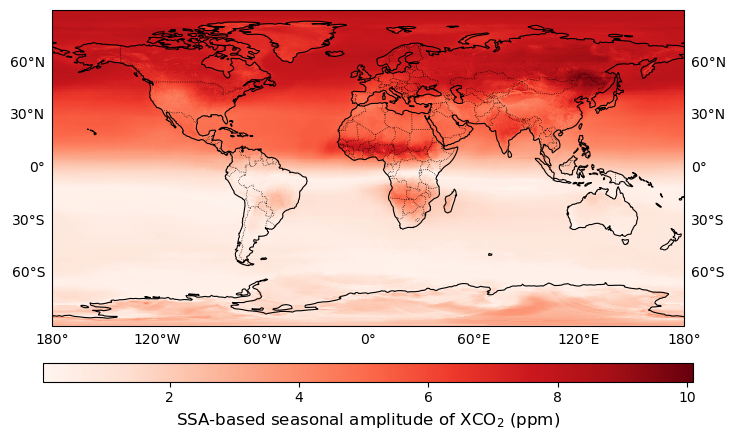

[INFO] Saved SSA seasonal amplitude map.
[INFO] Saved SSA 5-year std map.


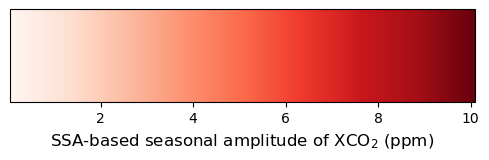

In [4]:
OUTDIR = Path("figs_xco2_seasonal_variation")
npz_path = OUTDIR / "xco2_ssa_seasonal_amplitude_and_std_2019_2024.npz"

data = np.load(npz_path)

lat_arr          = data["lat"]          
lon_arr          = data["lon"]              
ssa_clim         = data["ssa_clim"]        
seasonal_amp     = data["seasonal_amplitude"]
std_5yr_ssa      = data["std_5yr_ssa"]    

print("[INFO] loaded:", npz_path)

lat_arr = np.array(lat_arr)
lon_arr = np.array(lon_arr)
if lat_arr.ndim == 1 and lon_arr.ndim == 1:
    Lon2D, Lat2D = np.meshgrid(lon_arr, lat_arr)
else:
    Lon2D, Lat2D = lon_arr, lat_arr

fig1 = plt.figure(figsize=(10, 4.5))
ax1 = fig1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
gl = ax1.gridlines(draw_labels=True, linewidth=0.3, linestyle="--", alpha=0)
gl.top_labels = False
gl.right_labels = True
gl.bottom_labels = True
gl.left_labels = True

im1 = ax1.pcolormesh(
    Lon2D, Lat2D, seasonal_amp,  
    transform=ccrs.PlateCarree(),
    cmap="Reds"
)
cbar1 = fig1.colorbar(
    im1,
    ax=ax1,
    orientation="horizontal",
    pad=0.1,     
    fraction=0.05,
    shrink=1,    
    aspect=35    
)
cbar1.set_label("SSA-based seasonal amplitude of XCO$_2$ (ppm)", fontsize=12)

fig1.tight_layout()
fig1.savefig(OUTDIR / "xco2_ssa_seasonal_amplitude_2019_2024.png",
             dpi=300, bbox_inches="tight")
plt.show()
print("[INFO] Saved SSA seasonal amplitude map.")

fig2 = plt.figure(figsize=(10, 4.5))
ax2 = fig2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
gl = ax2.gridlines(draw_labels=True, linewidth=0.3, linestyle="--", alpha=0)
gl.top_labels = False
gl.right_labels = True
gl.bottom_labels = True
gl.left_labels = True

im2 = ax2.pcolormesh(
    Lon2D, Lat2D, std_5yr_ssa,   
    transform=ccrs.PlateCarree(),
    cmap="Reds"
)

cbar2 = fig2.colorbar(
    im2,
    ax=ax2,
    orientation="horizontal",
    pad=0.1,   
    fraction=0.05,
    shrink=1, 
    aspect=35   
)

cbar2.set_label("5-year std of SSA seasonal XCO$_2$ (ppm)", fontsize=12)

fig2.tight_layout()
fig2.savefig(OUTDIR / "xco2_ssa_std_5yr_2019_2024.png",
             dpi=300, bbox_inches="tight")
plt.close(fig2)
print("[INFO] Saved SSA 5-year std map.")



vmin = np.nanmin(seasonal_amp)
vmax = np.nanmax(seasonal_amp)

fig_cb, ax_cb = plt.subplots(figsize=(6, 1.2))
import matplotlib.colors as colors
import matplotlib.cm as cm
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap="Reds")
sm.set_array([])

cbar = fig_cb.colorbar(
    sm,
    cax=ax_cb,
    orientation="horizontal"
)
cbar.set_label("SSA-based seasonal amplitude of XCO$_2$ (ppm)", fontsize=12)

fig_cb.savefig(
    OUTDIR / "colorbar_xco2_ssa_seasonal_amplitude.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

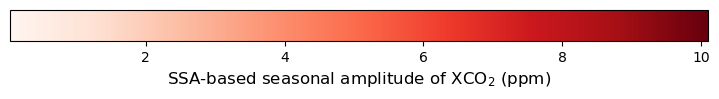

In [13]:

vmin = np.nanmin(seasonal_amp)
vmax = np.nanmax(seasonal_amp)

fig_cb, ax_cb = plt.subplots(figsize=(9, 0.4))
import matplotlib.colors as colors
import matplotlib.cm as cm
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap="Reds")
sm.set_array([])

cbar = fig_cb.colorbar(
    sm,
    cax=ax_cb,
    orientation="horizontal"
)
cbar.set_label("SSA-based seasonal amplitude of XCO$_2$ (ppm)", fontsize=12)

fig_cb.savefig(
    OUTDIR / "colorbar_xco2_ssa_seasonal_amplitude.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

### Lat Distribution

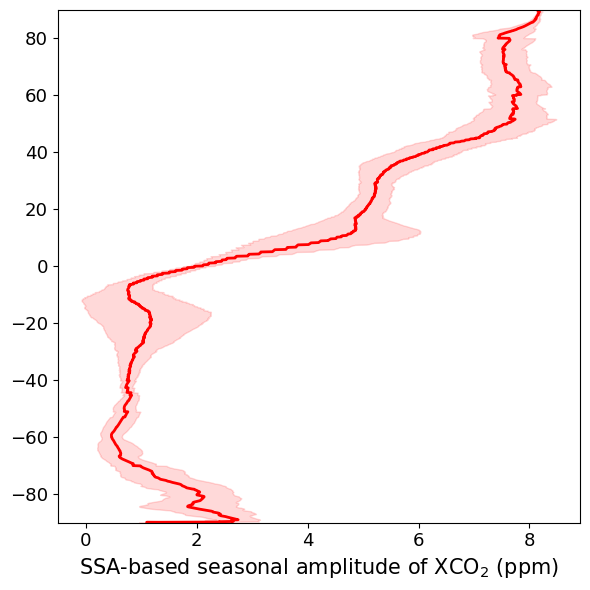

[INFO] Saved: figs_xco2_seasonal_variation/xco2_ssa_seasonal_amplitude_lat_profile_mean_std.png


In [11]:
def lat_profile_mean_std(Lat2D, field2D, bin_width=0.5, lat_min=-90, lat_max=90):
    lat_flat = Lat2D.ravel()
    val_flat = field2D.ravel()
    m = np.isfinite(lat_flat) & np.isfinite(val_flat)
    lat_flat = lat_flat[m]
    val_flat = val_flat[m]

    bins = np.arange(lat_min, lat_max + bin_width, bin_width)
    centers = (bins[:-1] + bins[1:]) / 2.0
    idx = np.digitize(lat_flat, bins) - 1

    mean = np.full_like(centers, np.nan, dtype=float)
    std  = np.full_like(centers, np.nan, dtype=float)

    for i in range(len(centers)):
        vv = val_flat[idx == i]
        if vv.size > 0:
            mean[i] = np.nanmean(vv)
            std[i]  = np.nanstd(vv, ddof=0)

    return centers, mean, std

if lat_arr.ndim == 1 and seasonal_amp.ndim == 2 and seasonal_amp.shape[0] == lat_arr.size:
    lat_centers = lat_arr
    mean_lat = np.nanmean(seasonal_amp, axis=1)
    std_lat  = np.nanstd(seasonal_amp, axis=1)
else:
    lat_centers, mean_lat, std_lat = lat_profile_mean_std(Lat2D, seasonal_amp, bin_width=0.5)

fig = plt.figure(figsize=(6, 6.0))
ax = fig.add_subplot(1, 1, 1)

ax.plot(mean_lat, lat_centers, linewidth=2, color='red')
ax.fill_betweenx(lat_centers, mean_lat - std_lat, mean_lat + std_lat, alpha=0.15, color='red')

ax.set_ylabel("")
ax.set_xlabel("SSA-based seasonal amplitude of XCO$_2$ (ppm)", fontsize=15) 
ax.set_ylim(-90, 90)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.tight_layout()
out_png = OUTDIR / "xco2_ssa_seasonal_amplitude_lat_profile_mean_std.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
print("[INFO] Saved:", out_png)


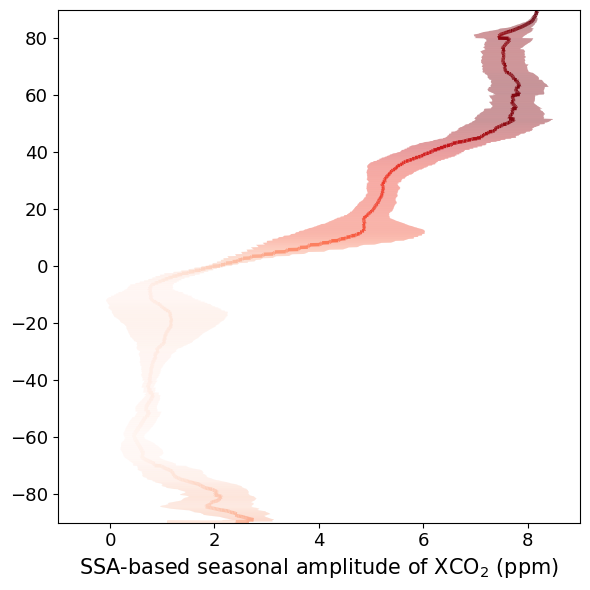

In [ ]:
def lat_profile_mean_std(Lat2D, field2D, bin_width=0.5, lat_min=-90, lat_max=90):
    lat_flat = Lat2D.ravel()
    val_flat = field2D.ravel()
    m = np.isfinite(lat_flat) & np.isfinite(val_flat)
    lat_flat = lat_flat[m]
    val_flat = val_flat[m]

    bins = np.arange(lat_min, lat_max + bin_width, bin_width)
    centers = (bins[:-1] + bins[1:]) / 2.0
    idx = np.digitize(lat_flat, bins) - 1

    mean = np.full_like(centers, np.nan, dtype=float)
    std  = np.full_like(centers, np.nan, dtype=float)

    for i in range(len(centers)):
        vv = val_flat[idx == i]
        if vv.size > 0:
            mean[i] = np.nanmean(vv)
            std[i]  = np.nanstd(vv, ddof=0)

    return centers, mean, std

if lat_arr.ndim == 1 and seasonal_amp.ndim == 2 and seasonal_amp.shape[0] == lat_arr.size:
    lat_centers = lat_arr
    mean_lat = np.nanmean(seasonal_amp, axis=1)
    std_lat  = np.nanstd(seasonal_amp, axis=1)
else:
    lat_centers, mean_lat, std_lat = lat_profile_mean_std(Lat2D, seasonal_amp, bin_width=0.5)

fig = plt.figure(figsize=(6, 6.0))
ax = fig.add_subplot(1, 1, 1)

from matplotlib.collections import LineCollection
import matplotlib.colors as colors

cmap = plt.get_cmap("Reds")
norm = colors.Normalize(vmin=np.nanmin(mean_lat),
                        vmax=np.nanmax(mean_lat))

points = np.array([mean_lat, lat_centers]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=2.5)
lc.set_array(mean_lat)

ax.add_collection(lc)


from matplotlib.collections import PolyCollection

polys = []
colors_list = []

for i in range(len(lat_centers) - 1):
    y0, y1 = lat_centers[i], lat_centers[i+1]

    x0_low  = mean_lat[i]   - std_lat[i]
    x0_high = mean_lat[i]   + std_lat[i]
    x1_low  = mean_lat[i+1] - std_lat[i+1]
    x1_high = mean_lat[i+1] + std_lat[i+1]

    poly = [
        (x0_low,  y0),
        (x0_high, y0),
        (x1_high, y1),
        (x1_low,  y1)
    ]
    polys.append(poly)

    c = cmap(norm(mean_lat[i]))
    colors_list.append((*c[:3], 0.5))  # alpha = 0.2

pc = PolyCollection(polys, facecolors=colors_list, edgecolors='none')
ax.add_collection(pc)

ax.set_ylabel("")
ax.set_xlabel("SSA-based seasonal amplitude of XCO$_2$ (ppm)", fontsize=15) 
ax.set_ylim(-90, 90)
ax.set_xlim(-1, 9)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.tight_layout()
plt.show()